# Time series forecasting

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

In [2]:
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [3]:
mobile_sales.dtypes

DATE     datetime64[ns]
Sales           float64
dtype: object

In [4]:
mobile_sales.Sales.describe()

count      198.000000
mean     10842.757576
std       2605.006293
min        108.000000
25%       8856.000000
50%      10745.000000
75%      12399.750000
max      23740.000000
Name: Sales, dtype: float64

In [5]:
mobile_sales.DATE.describe()

/var/folders/pb/lctdnpp509v1l7y5t98dvxj00000gn/T/ipykernel_81424/20359885.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  mobile_sales.DATE.describe()


count                     217
unique                    217
top       2001-01-01 00:00:00
freq                        1
first     2001-01-01 00:00:00
last      2019-01-01 00:00:00
Name: DATE, dtype: object

In [6]:
12*18 + 1

217

In [7]:
mobile_sales.isna().sum()

DATE      0
Sales    19
dtype: int64

In [8]:
mobile_sales.set_index('DATE', inplace=True)
mobile_sales

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0
...,...
2018-09-01,13838.0
2018-10-01,15351.0
2018-11-01,15615.0


<AxesSubplot:xlabel='DATE'>

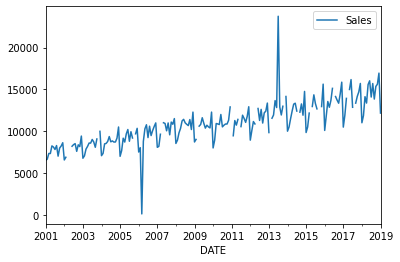

In [9]:
mobile_sales.plot()

In [10]:
mobile_sales.Sales.describe()

count      198.000000
mean     10842.757576
std       2605.006293
min        108.000000
25%       8856.000000
50%      10745.000000
75%      12399.750000
max      23740.000000
Name: Sales, dtype: float64

### Imputation

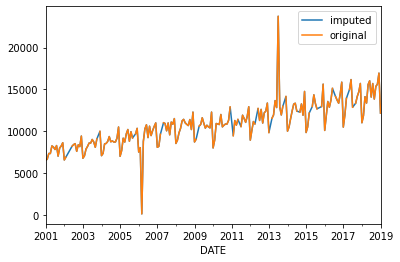

In [11]:
mobile_sales.Sales.interpolate(method='linear').plot(label='imputed')
mobile_sales.Sales.plot(label='original')
plt.legend()

In [12]:
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

### Outliers

<AxesSubplot:>

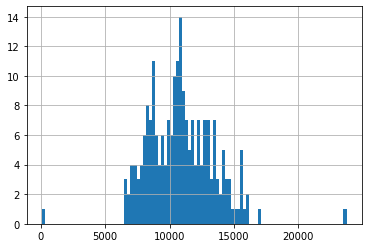

In [13]:
mobile_sales.Sales.hist(bins=100)

In [14]:
mobile_sales.Sales.quantile(0.99)

16144.480000000001

In [15]:
mobile_sales.Sales.quantile(0.01)

6573.36

<AxesSubplot:xlabel='DATE'>

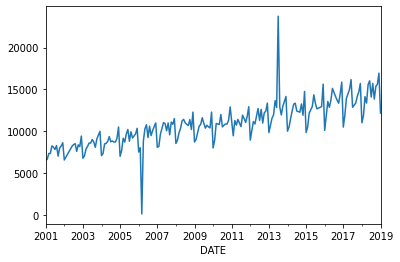

In [16]:
mobile_sales.Sales.plot()

### Clean

<AxesSubplot:xlabel='DATE'>

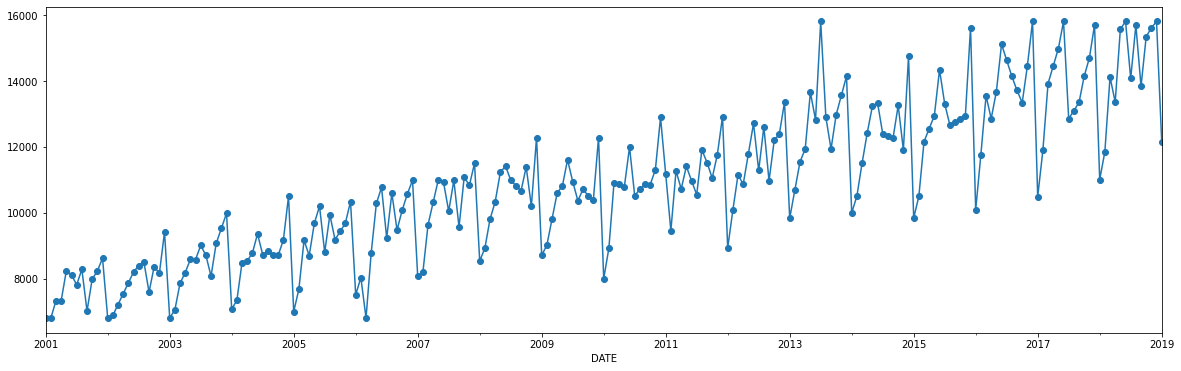

In [17]:
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.set_index('DATE', inplace=True)

# linear interpolation 
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

# anomalies - clip quantiles
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))

# plot
mobile_sales.Sales.plot(style='-o', figsize=(20,6))

### rolling average

<AxesSubplot:xlabel='DATE'>

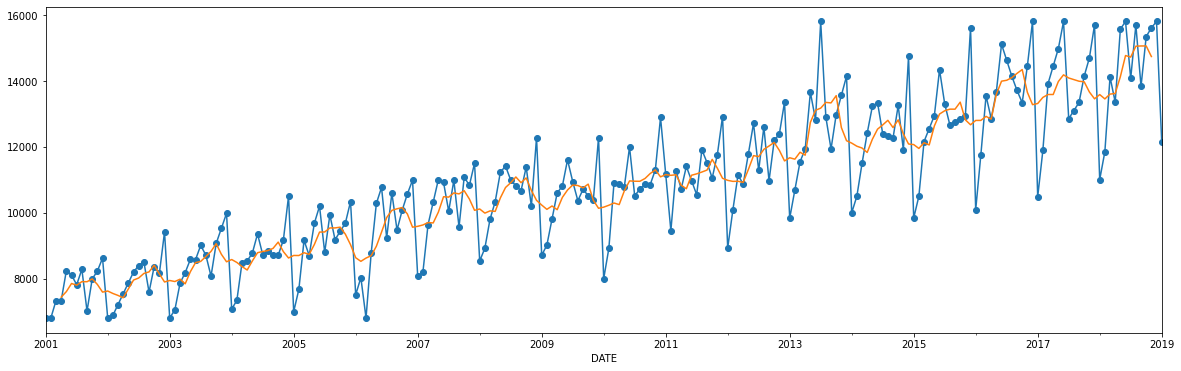

In [18]:
mobile_sales.Sales.plot(style='-o', figsize=(20,6))
mobile_sales.Sales.rolling(6, center=True).mean().plot(figsize=(20,6))

In [19]:
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='additive')

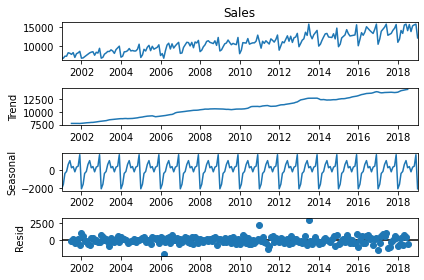

In [20]:
model.plot();

<AxesSubplot:xlabel='DATE'>

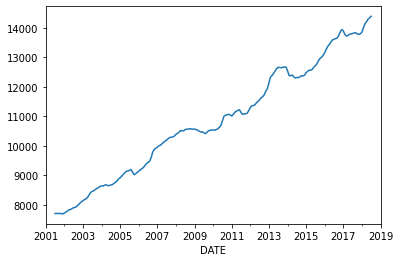

In [21]:
model.trend.plot()

<AxesSubplot:xlabel='DATE'>

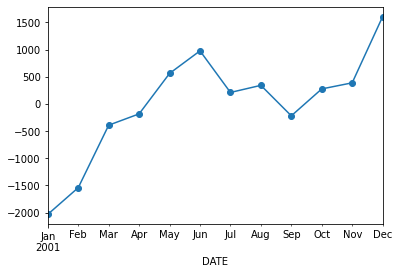

In [22]:
model.seasonal[:12].plot(style='-o')

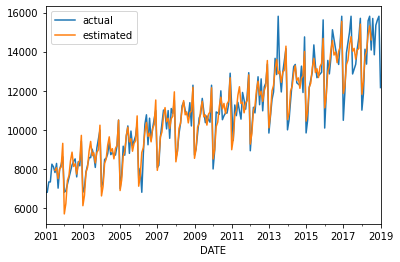

In [23]:
mobile_sales.Sales.plot(label='actual')
(model.trend + model.seasonal).plot(label='estimated')
plt.legend()

<AxesSubplot:ylabel='Density'>

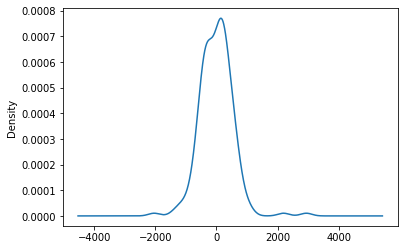

In [24]:
model.resid.plot(kind='kde')

### Decomposition From Scratch

<AxesSubplot:xlabel='DATE'>

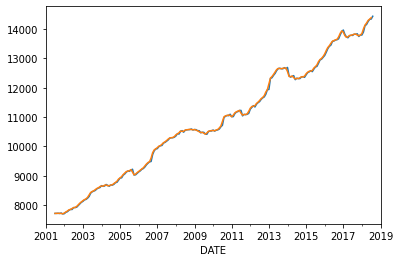

In [25]:
trend = mobile_sales.Sales.rolling(12, center=True).mean()  # temporary
trend.plot()
model.trend.plot()

<AxesSubplot:xlabel='DATE'>

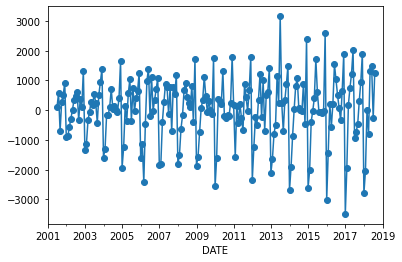

In [26]:
de_trend = mobile_sales.Sales - trend
de_trend.plot(style='-o')

<AxesSubplot:xlabel='DATE'>

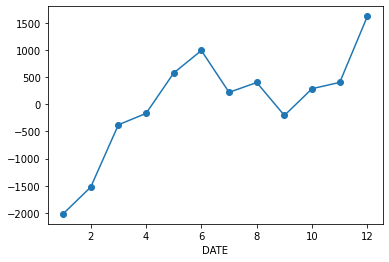

In [27]:
dtf = de_trend.reset_index()
dtf.groupby(dtf.DATE.dt.month)['Sales'].mean().plot(style='-o')

<AxesSubplot:xlabel='DATE'>

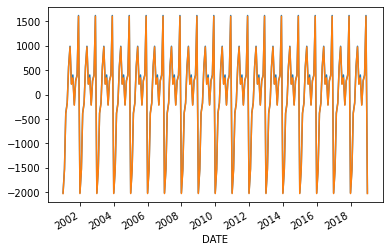

In [28]:
plt.plot(dtf.DATE, dtf.groupby(dtf.DATE.dt.month)['Sales'].transform('mean'))
model.seasonal.plot()

<AxesSubplot:>

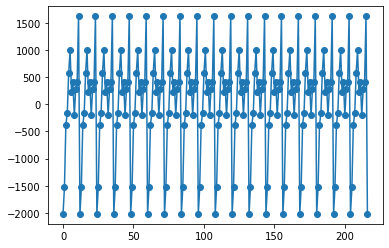

In [29]:
dtf['season'] = dtf.groupby(dtf.DATE.dt.month)['Sales'].transform('mean')
dtf['season'].plot(style='-o')

<AxesSubplot:xlabel='DATE'>

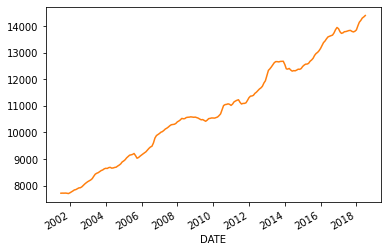

In [30]:
trend_2 = pd.Series((mobile_sales.values[:, 0] - dtf['season']).rolling(12, center=True).mean(), index=model.trend.index)
plt.plot(trend_2)
model.trend.plot()

---
## Simple Forecasting

In [31]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

In [32]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

test_x.head()

,Sales
DATE,
2018-02-01,11852.0
2018-03-01,14123.0
2018-04-01,13360.0
2018-05-01,15576.0
2018-06-01,15809.4


### Naive Method

MAE : 3434.233
RMSE : 3697.005
MAPE: 0.23


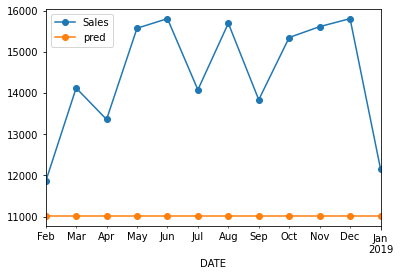

In [33]:
test_x['pred'] = train_x['Sales'].iloc[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Mean Method

MAE : 3786.031
RMSE : 4025.906
MAPE: 0.255


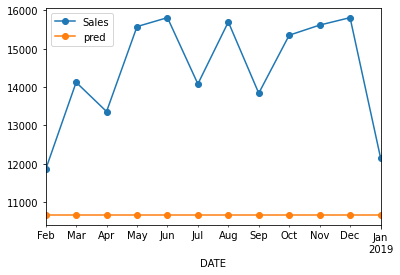

In [34]:
test_x['pred'] = train_x['Sales'].mean()

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Seasonal Naive

MAE : 800.867
RMSE : 1067.837
MAPE: 0.055


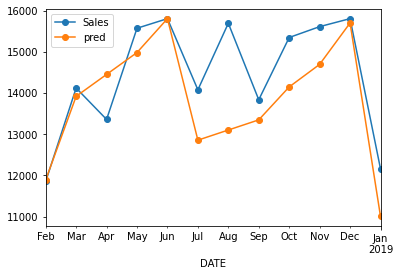

In [36]:
for i in test_x.index:
    test_x.loc[i]['pred'] = train_x.loc[i - pd.DateOffset(years=1)]['Sales']

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

### Drift Method

MAE : 3321.482
RMSE : 3586.323
MAPE: 0.223


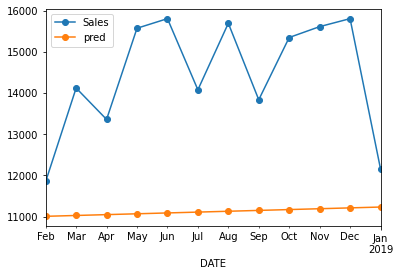

In [37]:
y_t = train_x['Sales'].iloc[-1]
y_0 = train_x['Sales'].iloc[0]

m = (y_t - y_0) / len(train_x)

h = np.linspace(0,len(test_x)-1, len(test_x))

test_x['pred'] = m*h + y_t

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

### Moving Average Method

MAE : 1692.467
RMSE : 1875.03
MAPE: 0.115


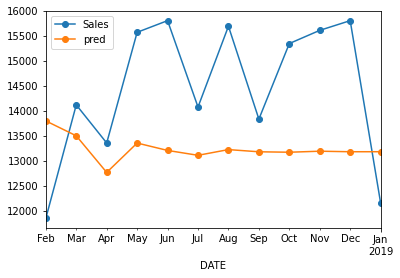

In [38]:
pred = train_x['Sales'].values

for i in range(12):
    pred = np.append(pred, pred[-3:].mean())
    
test_x['pred'] = pred[-12:]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

---
# Smoothing Methods

### SES

In [39]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales)
_ = model.fit(smoothing_level=0.8)

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


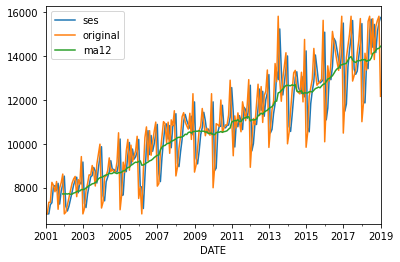

In [40]:
pred = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=0.8).fittedvalues)

pred.plot(label='ses')
mobile_sales.Sales.plot(label='original')
mobile_sales.Sales.rolling(12).mean().plot(label='ma12')
plt.legend()

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


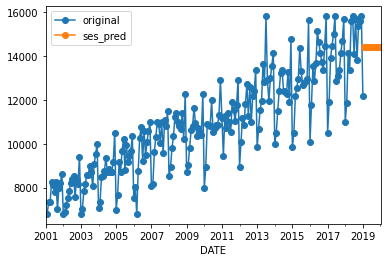

In [41]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=0.15)
pred = model.forecast(12)

mobile_sales.Sales.plot(label='original', style='-o')
pred.plot(label='ses_pred', style='-o')
plt.legend()

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE : 1365.057
RMSE : 1560.036
MAPE: 0.094


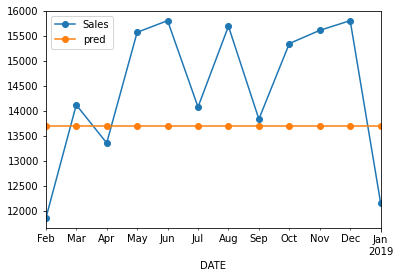

In [42]:
model = sm.tsa.SimpleExpSmoothing(train_x.Sales).fit()
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

In [43]:
m = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add')

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


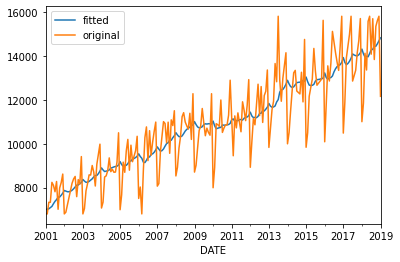

In [44]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add').fit()
model.fittedvalues.plot(label='fitted')
mobile_sales.Sales.plot(label='original')
plt.legend()

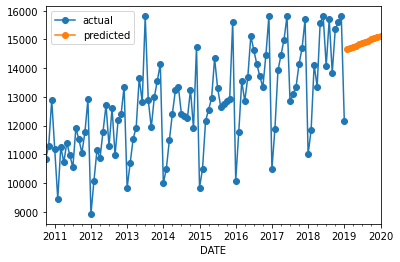

In [45]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MAE : 1163.712
RMSE : 1352.428
MAPE: 0.083


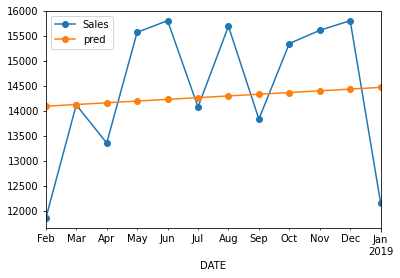

In [46]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add').fit()
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


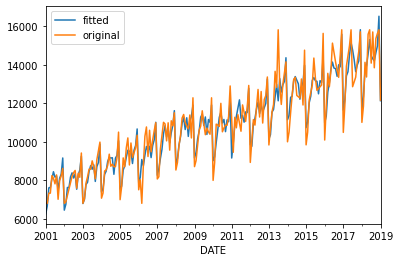

In [47]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add', seasonal='add').fit()
model.fittedvalues.plot(label='fitted')
mobile_sales.Sales.plot(label='original')
plt.legend()

<AxesSubplot:xlabel='DATE'>

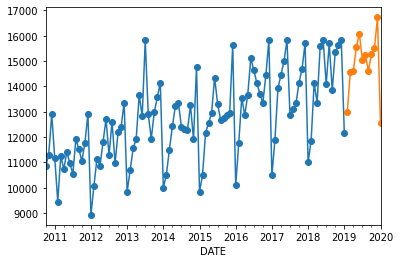

In [48]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o')
pred.plot(style='-o')

MAE : 557.48
RMSE : 614.448
MAPE: 0.038


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


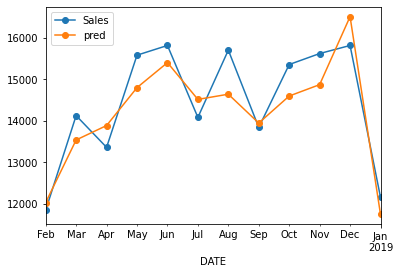

In [49]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='mul').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

## Stationarity

In [50]:
sm.tsa.stattools.adfuller(mobile_sales.Sales)[1]

0.9789233920172064

In [51]:
def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1] 
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')

adf_test(mobile_sales.Sales)

Sequence is not stationary


**1 residual**

<AxesSubplot:xlabel='DATE'>

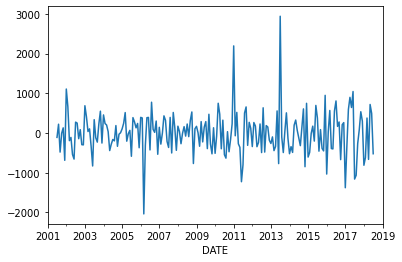

In [52]:
model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='additive')
model.resid.plot()

In [53]:
adf_test(model.resid.dropna())

Sequence is stationary


**2 differenciation**

<AxesSubplot:xlabel='DATE'>

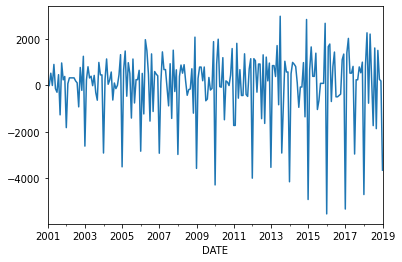

In [54]:
mobile_sales.Sales.diff().plot()

In [55]:
adf_test(mobile_sales.Sales.diff().dropna())

Sequence is stationary


## ACF / PACF

In [56]:
corr = []
for lag in range(40):
    corr.append(np.corrcoef(mobile_sales.Sales[lag:], mobile_sales.Sales.shift(lag).dropna())[0][1])

<StemContainer object of 3 artists>

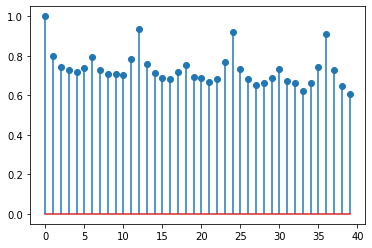

In [57]:
plt.stem(corr)

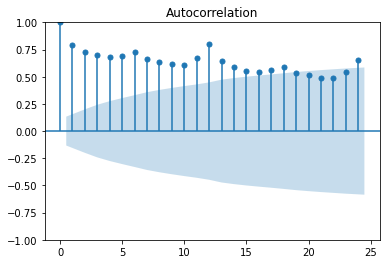

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(mobile_sales.Sales);

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


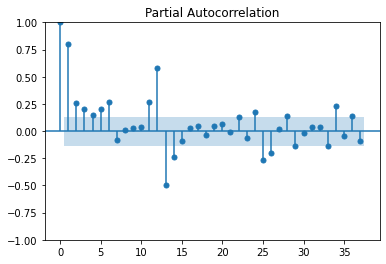

In [59]:
plot_pacf(mobile_sales.Sales, lags=37);

<AxesSubplot:xlabel='DATE'>

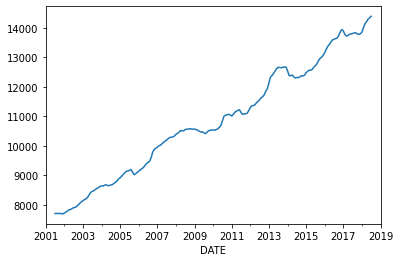

In [60]:
model.trend.plot()

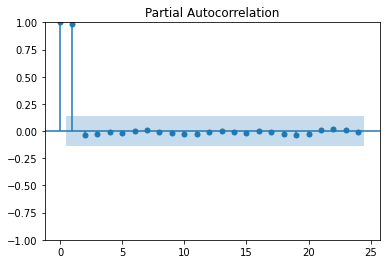

In [61]:
plot_pacf(model.trend.dropna());

<AxesSubplot:xlabel='DATE'>

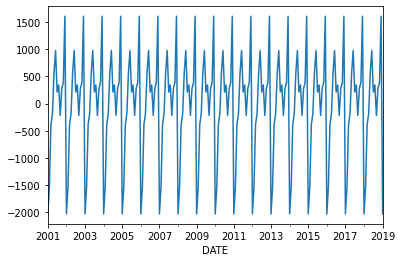

In [62]:
model.seasonal.plot()

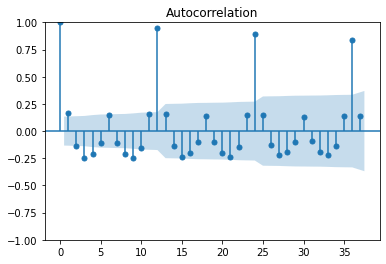

In [63]:
plot_acf(model.seasonal.dropna(), lags=37);

<AxesSubplot:xlabel='DATE'>

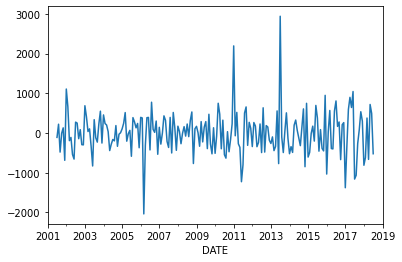

In [64]:
model.resid.plot()

- residual -- cannot be predicted furhter- this is truly noise- and there nothing that can be done here. Mean

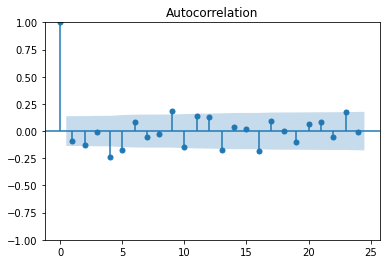

In [65]:
plot_acf(model.resid.dropna());

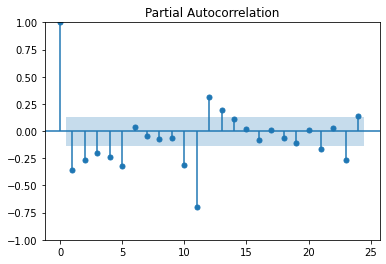

In [66]:
plot_pacf(mobile_sales.Sales.diff().dropna());

seasonality
trend
acf vs pacf
acf - completely

guessing ARIMA HP -- old thing-- many edge cases - not very useful -- grid search

# ARIMA

### AR

In [67]:
train_x.head()

,Sales
DATE,
2001-01-01,6802.44
2001-02-01,6802.44
2001-03-01,7332.00
2001-04-01,7332.00
2001-05-01,8240.00


In [68]:
train_x_st = train_x.copy()

train_x_st.Sales = train_x_st.Sales.diff(1)  # stationarise


train_x_st.dropna(inplace=True)
adf_test(train_x_st.Sales)

Sequence is stationary


In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### AR

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE : 846.409
RMSE : 995.916
MAPE: 0.058


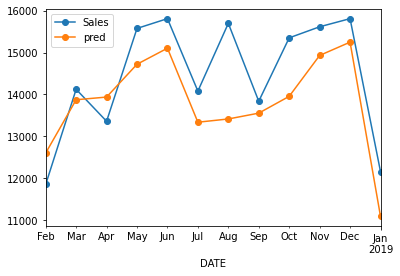

In [70]:
model = SARIMAX(train_x_st.Sales, order=(24, 0, 0)) 
model = model.fit(disp=False)


test_x['pred'] = model.forecast(steps=12)

# Integrating the trend back!
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

# Plotting
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### MA

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE : 706.53
RMSE : 861.382
MAPE: 0.051


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


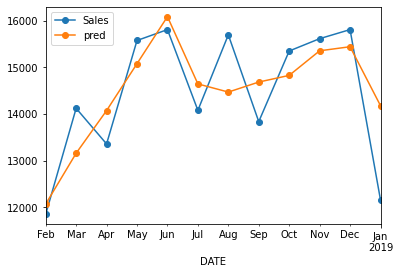

In [71]:
model = SARIMAX(train_x_st.Sales, order=(0, 0, 12)) 
model = model.fit(disp=False)


test_x['pred'] = model.forecast(steps=12)

# Integrating the trend back!
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

# Plotting
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### ARMA

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAE : 654.958
RMSE : 898.69
MAPE: 0.046


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


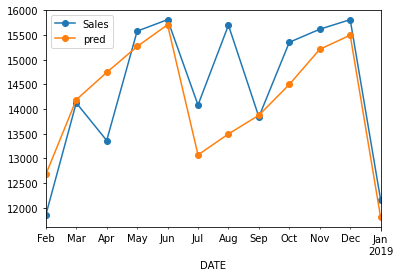

In [72]:
model = SARIMAX(train_x_st.Sales, order=(12, 0, 3)) 
model = model.fit(disp=False)


test_x['pred'] = model.forecast(steps=12)

# Integrating the trend back!
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

# Plotting
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### ARIMA

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAE : 643.936
RMSE : 871.904
MAPE: 0.045


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


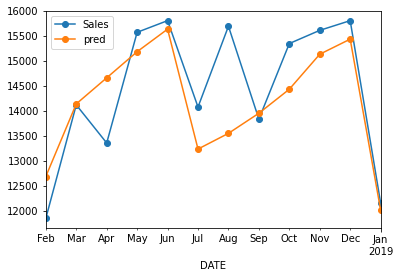

In [73]:
model = SARIMAX(train_x.Sales, order=(12, 1, 3)) 
model = model.fit(disp=False)


test_x['pred'] = model.forecast(steps=12)

# Plotting
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### SARIMA

<AxesSubplot:xlabel='DATE'>

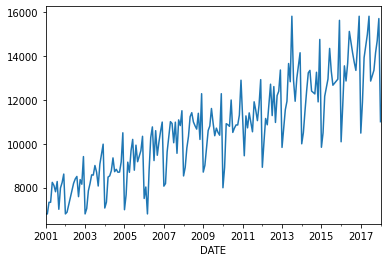

In [74]:
train_x.Sales.plot()

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE : 563.764
RMSE : 676.131
MAPE: 0.039


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


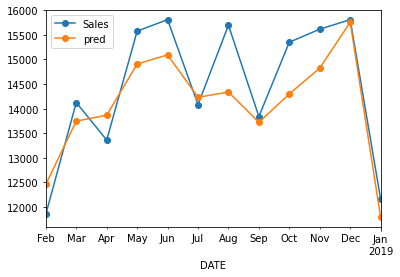

In [75]:
model = SARIMAX(train_x.Sales, order=(11, 1, 3), seasonal_order=(1, 0, 1, 12)) 
model = model.fit(disp=False)


test_x['pred'] = model.forecast(steps=12)

# Plotting
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

In [76]:
model.get_forecast(steps=12).conf_int(0.05).values

array([[10883.32005352, 14031.34261401],
       [12124.58387632, 15367.02663117],
       [12220.40778044, 15511.65801384],
       [13254.5715996 , 16560.7737727 ],
       [13419.90383024, 16766.55072442],
       [12552.5465711 , 15907.41482328],
       [12632.28327536, 16040.51045786],
       [12001.96368039, 15442.11685732],
       [12574.66197972, 16020.817395  ],
       [13068.31847609, 16581.45753538],
       [13999.92936692, 17517.79722029],
       [10007.635493  , 13569.06136702]])

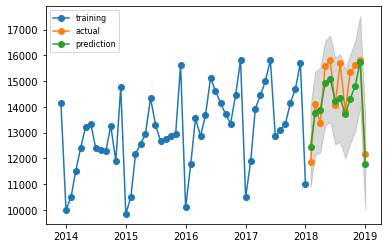

In [78]:
test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(alpha=0.05).values


plt.plot(train_x['Sales'][-50:], '-o', label='training')
plt.plot(test_x['Sales'], '-o', label='actual')
plt.plot(test_x['pred'], '-o', label='prediction')
plt.fill_between(test_x.index, test_x['lower'], test_x['upper'], 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

### SARIMAX

In [79]:
df = pd.read_csv('exog.csv')
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [80]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
df.head(5)

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


<AxesSubplot:xlabel='date'>

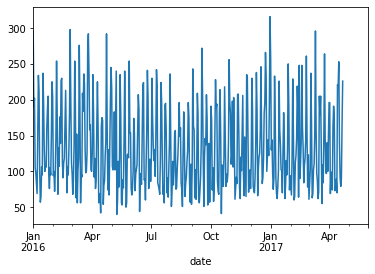

In [81]:
df.total.plot()

<AxesSubplot:xlabel='date'>

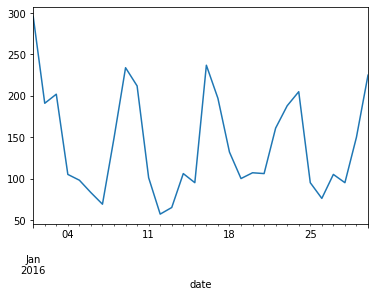

In [82]:
df.total[:30].plot()

In [83]:
df.groupby('weekday')['total'].mean()

weekday
Friday       148.840580
Monday        90.691176
Saturday     228.101449
Sunday       180.338235
Thursday      98.720588
Tuesday       93.838235
Wednesday     94.411765
Name: total, dtype: float64

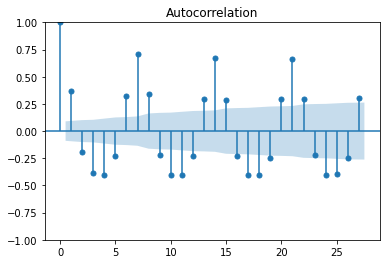

In [84]:
plot_acf(df.total.dropna());

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


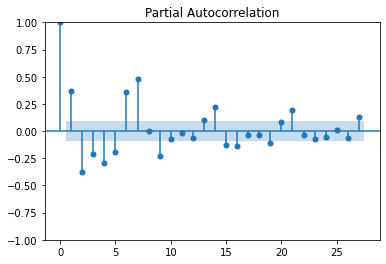

In [85]:
plot_pacf(df.total.dropna());

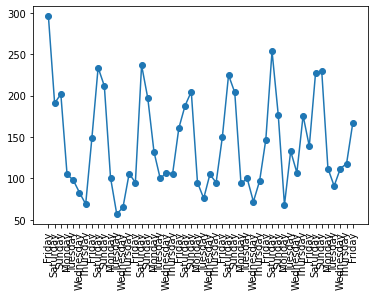

In [86]:
plt.plot(range(50),df['total'][:50], '-o')
plt.xticks(range(0,50), df['weekday'][:50],rotation = 90)
plt.show()

In [87]:
df.shape

(517, 3)

In [88]:
(478 - 436) / 7

6.0

In [89]:
df.dropna().shape

(478, 3)

In [90]:
train = df.iloc[:436]
test = df.iloc[436:]

In [91]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(1,0,1,7))
results = model.fit(disp=False)

predictions = results.predict(steps=42).rename('Predictions')

test = test.dropna()

predictions = predictions[-42:]

predictions.index= test.index

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE : 22.339
RMSE : 29.693
MAPE: 0.178


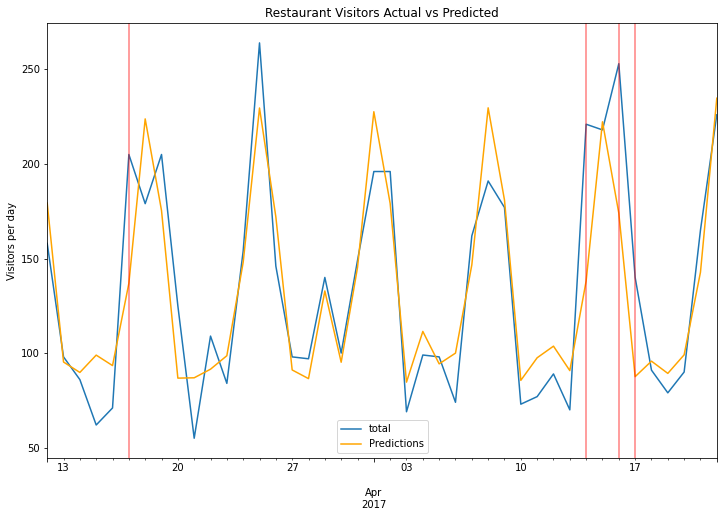

In [92]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

In [93]:
test.index[0]

Timestamp('2017-03-12 00:00:00')

In [94]:
model = SARIMAX(train['total'], exog=train['holiday'], order=(1,0,0),seasonal_order=(1,0,1,7))
results = model.fit(disp=False)

exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=test.index[0], end=test.index[-1], exog=exog_forecast).rename('Predictions')

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE : 18.907
RMSE : 23.267
MAPE: 0.163


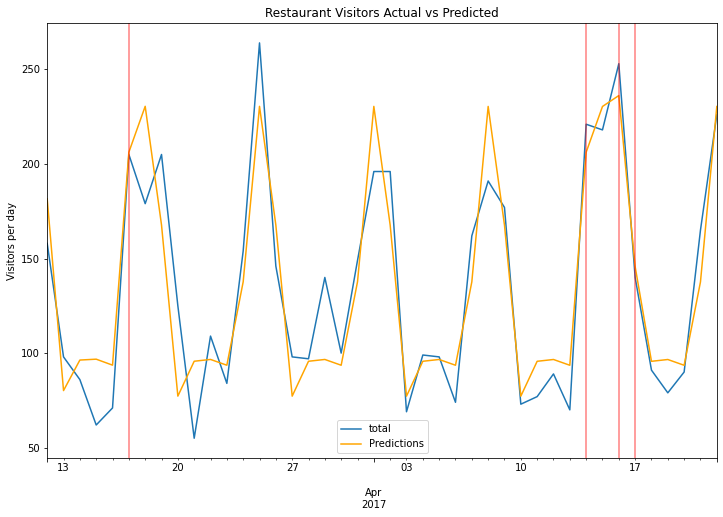

In [95]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

---
# Changepoints

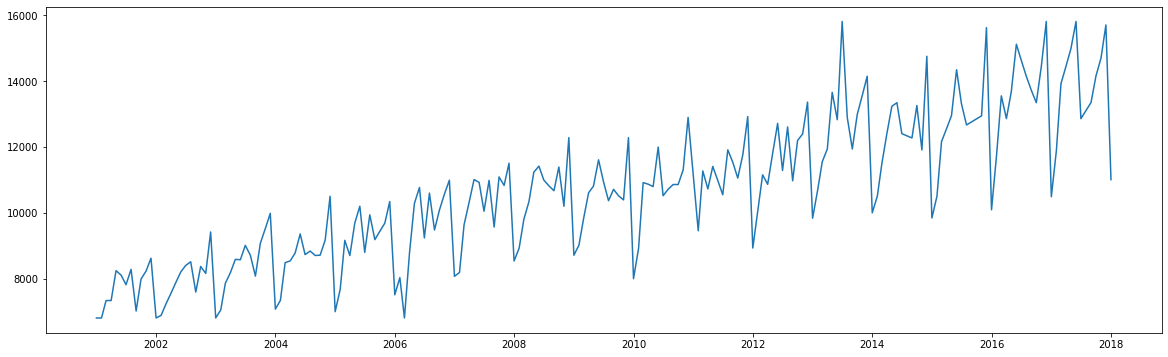

In [98]:
signal = train_x.Sales
plt.plot(signal)

In [100]:
# No need to explain this
def plot_changepoints(signal, changepoints):
    for cp in changepoints:
        plt.axvline(x=cp, color='#FA8072')
    plt.plot(signal, '-*', label='signal')

    start = 0
    trends = np.array([])
    for i in changepoints:
        x = np.arange(start, i)
        y = signal[start:i]
        l1 = np.polyfit(x, y, deg=1)
        trend = x*l1[0] + l1[1]
        trends = np.append(trends, trend)
        start = i

    plt.plot(trends, label='trend')
    plt.legend()
    plt.show()

In [108]:
m  = np.polyfit(np.arange(len(signal)), signal, deg=1)[0]
m

31.877208322305908

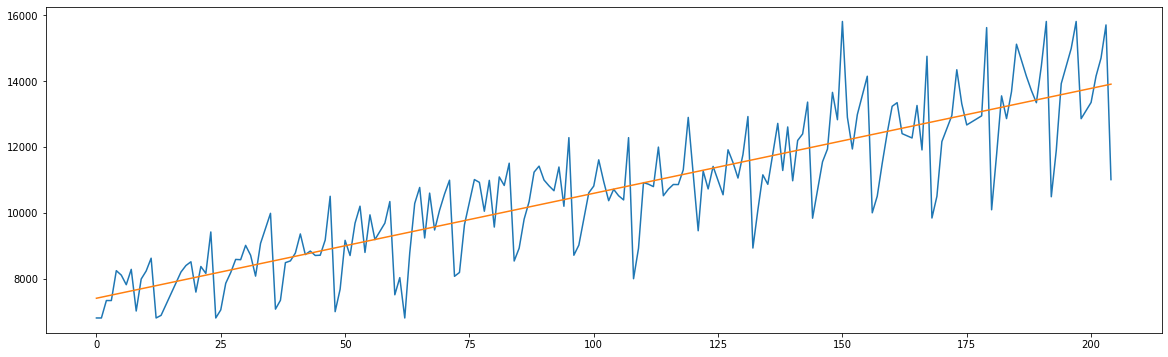

In [107]:
line = m*np.arange(len(signal)) + c

plt.plot(signal.values)
plt.plot(line)


<AxesSubplot:xlabel='DATE'>

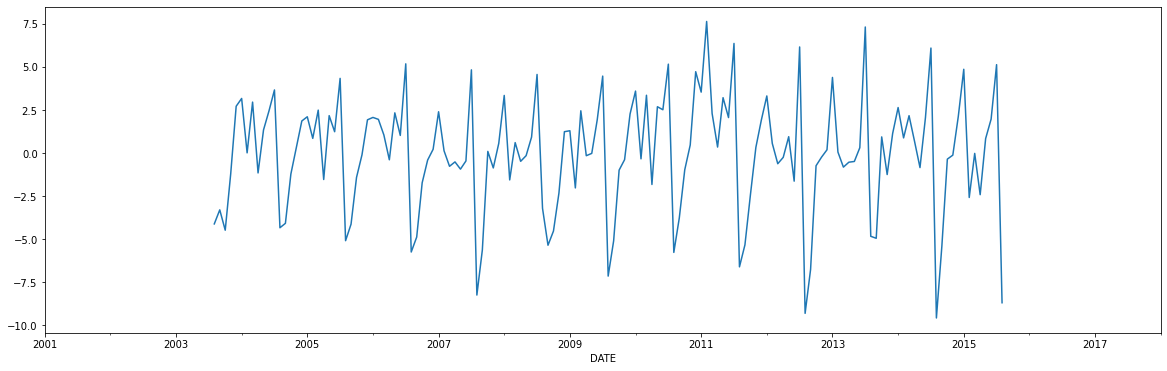

In [114]:
signal.rolling(window, center=True).apply(get_slope).diff().plot()

In [121]:
import warnings
warnings.filterwarnings('ignore')

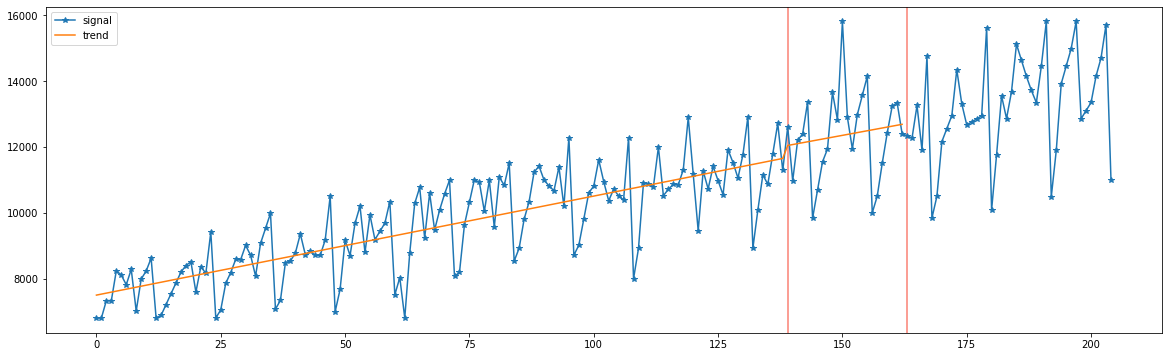

In [123]:
signal = train_x.Sales
window = 60   # already experimented with

def get_slope(y):
    return np.polyfit(np.arange(len(y)), y, deg=1)[0]

changepoints = signal.loc[
    abs(signal.rolling(window, center=True).apply(get_slope).diff()) > 9
].index

temp = signal.reset_index()
changepoints = temp.loc[temp['DATE'].isin(changepoints)].index.tolist()

plot_changepoints(signal.values, changepoints)

ruptures - library for changepoints

```
!pip install pystan~=2.14
!pip install fbprophet
```

In [126]:
df1 = df.copy()

You have to convert the dataframe to specific format

In [128]:
df['ds'] = pd.to_datetime(df.index)
df['y'] = df['total']
df = df[['ds', 'y', 'holiday']]
df.head(2)

,ds,y,holiday
date,,,
2016-01-01,2016-01-01,296.0,1
2016-01-02,2016-01-02,191.0,0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       852.818    0.00236155       98.0754           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       852.866   3.14326e-08        69.647      0.1894           1      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


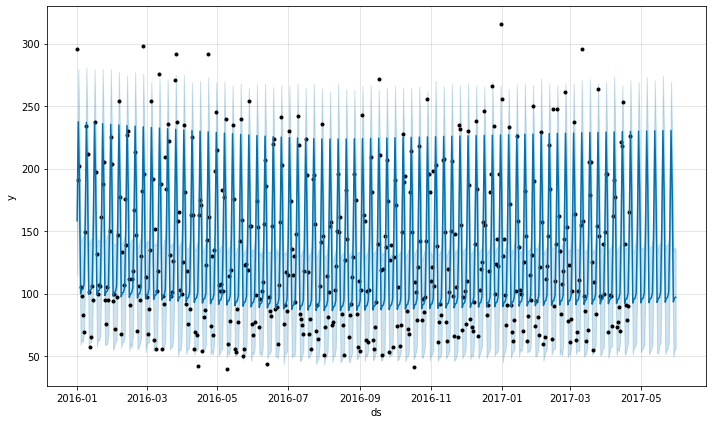

In [133]:
from prophet import Prophet

m = Prophet()
m.fit(df[['ds', 'y']][:-39])
future = m.make_future_dataframe(periods=39, freq='D')
forecast = m.predict(future)
m.plot(forecast);

In [142]:
f = forecast.tail(70)
f.set_index('ds', inplace=True)

<AxesSubplot:xlabel='ds'>

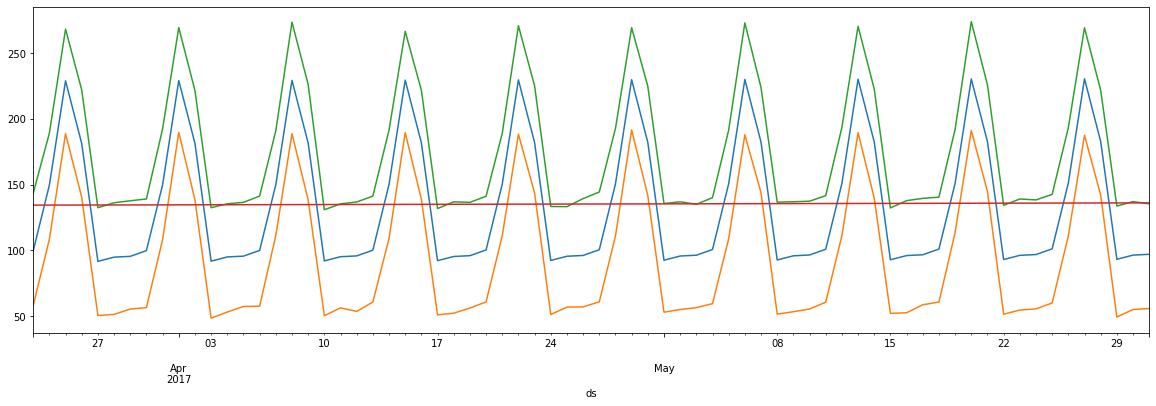

In [144]:
f.yhat.plot()
f.yhat_lower.plot()
f.yhat_upper.plot()
f.trend.plot()

In [145]:
f.columns

Index(['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

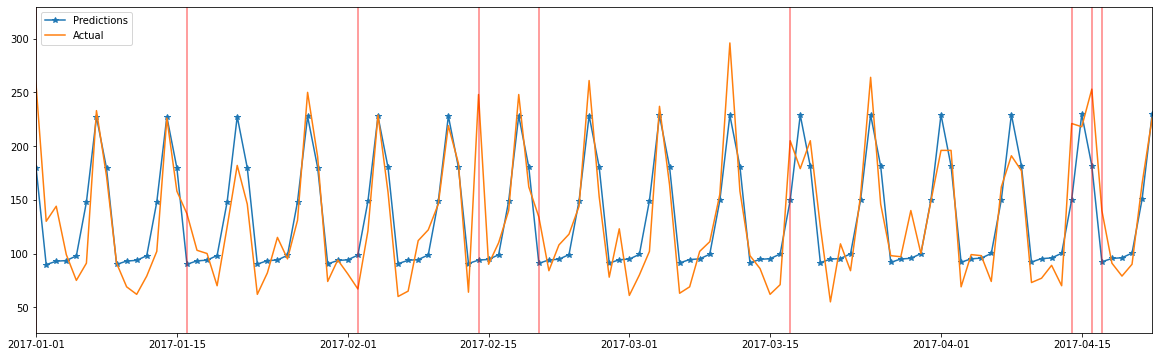

In [147]:
plt.plot(forecast['ds'], forecast['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
for x in df.query('holiday==1')['ds']: 
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-04-22'))
plt.legend()

In [148]:
performance(df['y'][:-39],forecast['yhat'][:-39])

MAE : 24.056
RMSE : 31.988
MAPE: 0.213


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        958.77      0.004027        96.846           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       959.083   6.57355e-05       89.6605   5.811e-07       0.001      222  LS failed, Hessian reset 
     199       959.087   7.67341e-07       73.4156      0.5608      0.3445      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       959.296    0.00114553       126.475   8.588e-06       0.001      361  LS failed, Hessian reset 
     268        959.45   9.33301e-05       109.487   8.988e-07       0.001      450  LS failed, Hessian reset 
     299       959.472    1.9293e-07       98.8653      0.7668      0.7668      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

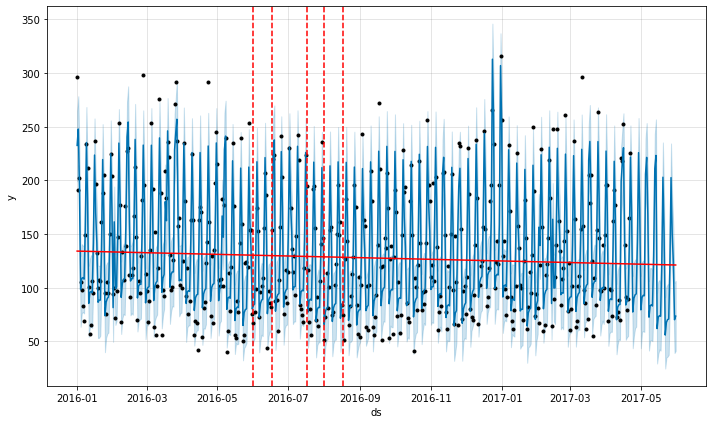

In [156]:
from prophet.plot import add_changepoints_to_plot

model2=Prophet(yearly_seasonality=True, weekly_seasonality=True)
model2.add_regressor('holiday') #adding holidays data in the model3
model2.fit(df[:-39])
forecast2 = model2.predict(df)
fig = model2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m, forecast2)

In [152]:
performance(df['y'][:-39],forecast2['yhat'][:-39])

MAE : 19.99
RMSE : 25.75
MAPE: 0.181


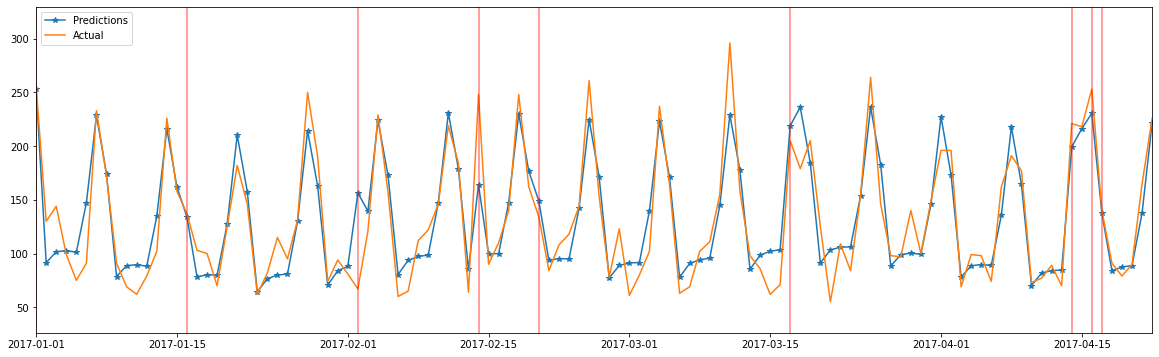

In [153]:
plt.plot(forecast2['ds'], forecast2['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
for x in df.query('holiday==1')['ds']: 
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-04-22'))
plt.legend()